In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import math as m
from sklearn.neighbors import KNeighborsClassifier as knn
import numpy as np

C:\Users\orteg\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\orteg\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\orteg\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv("model_only_data.csv")

In [3]:
df.head()

,Unnamed: 0,amount_requested,reason_for_loan,debt_to_income_ratio,zip_code,state,emp_length,policy_code,applicant_result
0,0,9600.0,Credit card refinancing,24.45,816xx,CO,4 years,1,1
1,1,6000.0,Home improvement,14.34,210xx,MD,10+ years,1,1
2,2,10000.0,Debt consolidation,25.35,890xx,NV,7 years,1,1
3,3,25000.0,Debt consolidation,7.17,640xx,MO,5 years,1,1
4,4,2000.0,Other,9.30,923xx,CA,4 years,1,1


## Breakdown of Features in Preparation for Models

### Handling Reason for Loan

In [4]:
df['reason_for_loan'].value_counts()[0:15]

Debt consolidation         75380
Credit card refinancing    29157
debt_consolidation         21376
Other                      15117
Home improvement            7677
other                       7180
credit_card                 4847
Major purchase              3911
Car financing               3751
home_improvement            2536
Medical expenses            2509
Home buying                 2364
Moving and relocation       1820
car                         1801
Business                    1706
Name: reason_for_loan, dtype: int64

In [5]:
home = ['home', 'house', 'kitchen', 'improvement', 'pool', 'remodel']
car = ['car', 'auto', 'motorcycle', 'vehicle', 'truck']
business = ['business']
medical = ['medical', 'remove']
debt_credit_issues = ['consolidation', 'credit', 'debt', 'refinancing', 'card', 'cc', 'consolidate', 'payoff', 
                      'interest', 'rate'] 
moving = ['move', 'moving']
major_purchase = ['purchase', 'major']
vacation = ['vacation']
wedding = ['wedding', 'ring']
student = ['student', 'college', 'education', 'school']
#If not categories match, then it will be placed into the 'other' category

Issues:
-Words have multiple meanings 
-Obervations can match multiple categories
-Misspelling
-Is what they write what they mean? (freedom loans)

I will go from specific to general debt consolidation and credit card issues. Lastly, we will have other.

In [6]:
df["reduced_reason"] = "Test"

In [7]:
df['reason_for_loan'] = df['reason_for_loan'].apply(str.lower)

In [8]:
my_dict = {"Debt/Credit Issues": debt_credit_issues, "Home": home, "Car": car, "Business": business, "Medical": medical, "Vacation": vacation, "Wedding": wedding,
        "Moving": moving, "Student": student, "Major Purchase": major_purchase}

In [9]:
for k, v in my_dict.items():
    for word in v:
        df.loc[df['reason_for_loan'].str.contains(word), 'reduced_reason'] = k

In [10]:
df['reduced_reason'].value_counts()

Debt/Credit Issues    100588
Car                    41132
Test                   25352
Home                   13738
Major Purchase          5698
Business                4177
Medical                 3871
Moving                  3317
Vacation                1792
Wedding                  236
Student                   99
Name: reduced_reason, dtype: int64

In [11]:
df['reason_for_loan'][df['reduced_reason'] == "Test"].value_counts()

other               22297
personal loan         159
green loan            139
renewable_energy      113
personal               91
                    ...  
summer 2012             1
educateme               1
relax relax             1
a safe bet              1
pay irs                 1
Name: reason_for_loan, Length: 1795, dtype: int64

I think that these are pretty great results!! Now we set the vague responses to "Other."

In [12]:
df['reduced_reason'][df['reduced_reason'] == "Test"] = "Other"

C:\Users\orteg\AppData\Local\Temp\ipykernel_18808\57583683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reduced_reason'][df['reduced_reason'] == "Test"] = "Other"


### Handling the Employee Length Column

I am going to rank the employment length. 0 is < 1 year and 10 is 10+ years.

In [13]:
ranking = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years',
          '8 years', '9 years', '10+ years']

In [14]:
df['emp_length'].value_counts()

< 1 year     94715
10+ years    37076
5 years      15176
2 years      10520
3 years       9224
1 year        8021
4 years       6866
6 years       5163
8 years       4645
7 years       4594
9 years       4000
Name: emp_length, dtype: int64

In [15]:
df_new = df.copy()

In [16]:
for index, value in enumerate(ranking):
    df_new.loc[df_new['emp_length'].str.contains(value), 'emp_length'] = str(index)

In [17]:
df_new.loc[df_new['emp_length'].str.contains('10+'), 'emp_length'] = str(10)

In [18]:
df_new['emp_length'].value_counts()

0     94715
10    37076
5     15176
2     10520
3      9224
1      8021
4      6866
6      5163
8      4645
7      4594
9      4000
Name: emp_length, dtype: int64

In [19]:
df_new['emp_length'] = df_new['emp_length'].astype("int64")

I will remove the useless index column.

In [20]:
df_new.drop(['Unnamed: 0'], inplace=True, axis=1)

### Dealing with Amount Requested

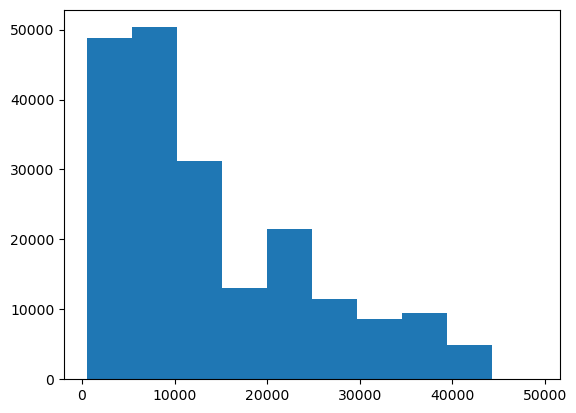

In [21]:
plt.hist(df_new['amount_requested'][df_new['amount_requested'] < 50000])
plt.show()

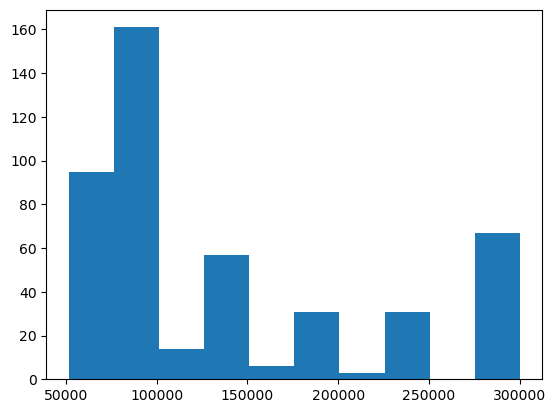

In [22]:
plt.hist(df_new['amount_requested'][df_new['amount_requested'] > 50000])
plt.show()

Considering the variety of reasons people apply for loans, I do not think it is valid to set any limit on the amount requested. I think the variation is natural.

### Dealing with DTI Ratio

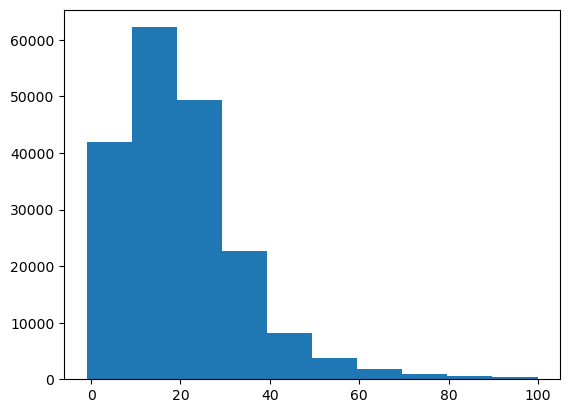

In [23]:
plt.hist(df_new['debt_to_income_ratio'][df_new['debt_to_income_ratio'] < 100])
plt.show()

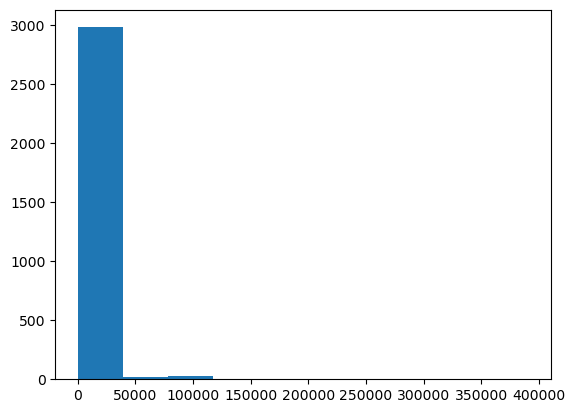

In [24]:
plt.hist(df_new['debt_to_income_ratio'][df_new['debt_to_income_ratio'] > 100])
plt.show()

In [25]:
len(df_new['debt_to_income_ratio'][df_new['debt_to_income_ratio'] > 100])

3037

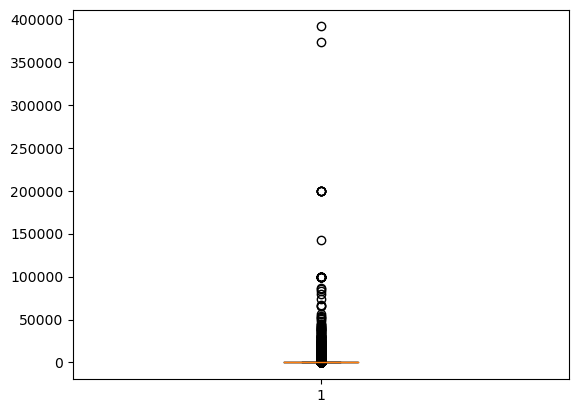

In [26]:
plt.boxplot(df_new['debt_to_income_ratio'])
plt.show()

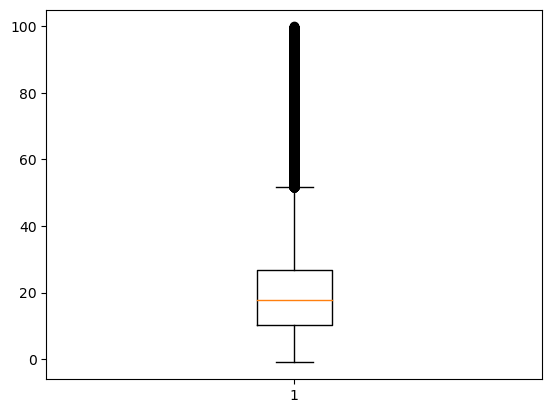

In [27]:
plt.boxplot(df_new['debt_to_income_ratio'][df_new['debt_to_income_ratio'] < 100])
plt.show()

Based on the odd behavior of ratios, I think removing the rows that have ratios greater than 100% is the best course of action. If I find arguments against this, I will change the method.

In [28]:
df_new = df_new[df_new['debt_to_income_ratio'] <= 100]

In [29]:
df_new.reset_index(drop=False, inplace=True)
df_new = df_new.drop('index', axis=1)

### Handling Categorical Variables

In [30]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196963 entries, 0 to 196962
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amount_requested      196963 non-null  float64
 1   reason_for_loan       196963 non-null  object 
 2   debt_to_income_ratio  196963 non-null  float64
 3   zip_code              196963 non-null  object 
 4   state                 196963 non-null  object 
 5   emp_length            196963 non-null  int64  
 6   policy_code           196963 non-null  int64  
 7   applicant_result      196963 non-null  int64  
 8   reduced_reason        196963 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 13.5+ MB


In [31]:
df_new.head()

,amount_requested,reason_for_loan,debt_to_income_ratio,zip_code,state,emp_length,policy_code,applicant_result,reduced_reason
0,9600.0,credit card refinancing,24.45,816xx,CO,4,1,1,Car
1,6000.0,home improvement,14.34,210xx,MD,10,1,1,Home
2,10000.0,debt consolidation,25.35,890xx,NV,7,1,1,Debt/Credit Issues
3,25000.0,debt consolidation,7.17,640xx,MO,5,1,1,Debt/Credit Issues
4,2000.0,other,9.30,923xx,CA,4,1,1,Other


In [32]:
cat_df = df_new.drop(['amount_requested', 'debt_to_income_ratio', 'reason_for_loan', 'applicant_result'], axis=1)

In [33]:
cat_df = pd.get_dummies(cat_df)

In [34]:
cat_df.shape

(196963, 969)

In [35]:
cat_df.head()

,emp_length,policy_code,zip_code_000xx,zip_code_002xx,zip_code_006xx,zip_code_007xx,zip_code_008xx,zip_code_009xx,zip_code_010xx,zip_code_011xx,...,reduced_reason_Car,reduced_reason_Debt/Credit Issues,reduced_reason_Home,reduced_reason_Major Purchase,reduced_reason_Medical,reduced_reason_Moving,reduced_reason_Other,reduced_reason_Student,reduced_reason_Vacation,reduced_reason_Wedding
0,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,10,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,7,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,5,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Handling Numeric Variables

In [36]:
num_df = df_new[['amount_requested', 'debt_to_income_ratio']]

In [37]:
std_num_df = preprocessing.scale(num_df, axis=0)

In [38]:
std_num_df = pd.DataFrame(std_num_df, columns = num_df.columns, index = num_df.index)
std_num_df.describe()

,amount_requested,debt_to_income_ratio
count,1.969630e+05,1.969630e+05
mean,-7.407462e-15,2.414309e-15
std,1.000003e+00,1.000003e+00
min,-1.092136e+00,-1.215644e+00
25%,-6.678269e-01,-6.067189e-01
50%,-2.752418e-01,-1.924590e-01
75%,4.544113e-01,3.077294e-01
max,2.266125e+01,4.141623e+00


### Combining and Dealing with Multicollinearity

In [39]:
 std_df = pd.concat([cat_df, std_num_df], axis = 1)

In [40]:
std_df_vif = std_df[['emp_length', 'policy_code', 'amount_requested', 'debt_to_income_ratio']]

In [41]:
vif_data = pd.DataFrame()
vif_data["feature"] = std_df_vif.columns
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(std_df_vif.values, i) for i in range(len(std_df_vif.columns))]
print(vif_data)

                feature       VIF
0            emp_length  1.773204
1           policy_code  1.745956
2      amount_requested  1.008505
3  debt_to_income_ratio  1.022933


The entire data frame was not tested for multicollinearity because the method struggles to handle the encoded columns.

### Splitting the Data

In [42]:
target_std = df_new['applicant_result']
predictors_std = std_df

In [43]:
pred_std_train, pred_std_test, tar_std_train, tar_std_test = train_test_split(predictors_std, target_std, 
                                                                              test_size = 0.2, random_state = 42)

### Model Metrics

In [44]:
from sklearn.metrics import (confusion_matrix, classification_report, precision_score, 
                             recall_score, f1_score, RocCurveDisplay, PrecisionRecallDisplay, 
                             accuracy_score, confusion_matrix, ConfusionMatrixDisplay)

### KNN

In [45]:
from sklearn.model_selection import cross_val_predict, cross_val_score

In [46]:
knn_new = knn(n_neighbors=m.ceil((len(pred_std_train))**(1/2)))
algorithm_knn = knn_new.fit(pred_std_train, tar_std_train)

In [47]:
algorithm_predict_train = cross_val_predict(algorithm_knn, pred_std_train, tar_std_train, cv=10)

In [48]:
print(classification_report(tar_std_train, algorithm_predict_train))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     77595
           1       0.91      0.87      0.89     79975

    accuracy                           0.89    157570
   macro avg       0.89      0.89      0.89    157570
weighted avg       0.89      0.89      0.89    157570



In [49]:
algorithm_predict_test = algorithm_knn.predict(pred_std_test)

In [50]:
print(classification_report(tar_std_test, algorithm_predict_test))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90     19434
           1       0.91      0.88      0.89     19959

    accuracy                           0.89     39393
   macro avg       0.89      0.89      0.89     39393
weighted avg       0.90      0.89      0.89     39393



### Logistic Regression

In [51]:
clf = LogisticRegression(random_state=42).fit(pred_std_train, tar_std_train)

C:\Users\orteg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
y_pred_lr = clf.predict(pred_std_test)

In [53]:
print(classification_report(tar_std_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     19434
           1       0.87      0.78      0.82     19959

    accuracy                           0.83     39393
   macro avg       0.84      0.83      0.83     39393
weighted avg       0.84      0.83      0.83     39393



In [54]:
cm_lr = confusion_matrix(tar_std_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)

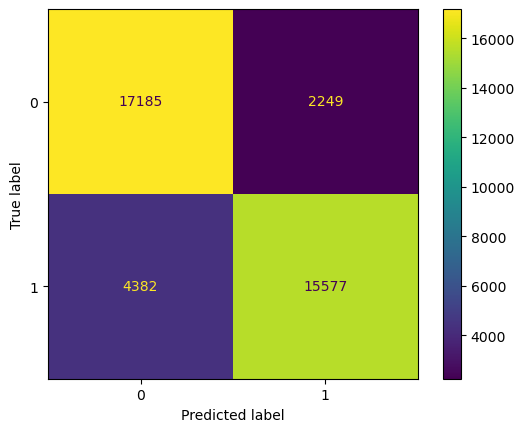

In [55]:
disp_lr.plot()
plt.show()

### Decision Tree

In [56]:
tree_clf = DecisionTreeClassifier(random_state=42)
algorithm_tree = tree_clf.fit(pred_std_train, tar_std_train)

In [57]:
y_pred = algorithm_tree.predict(pred_std_test)

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(tar_std_test, y_pred))
print(classification_report(tar_std_test, y_pred))

[[17231  2203]
 [ 2296 17663]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     19434
           1       0.89      0.88      0.89     19959

    accuracy                           0.89     39393
   macro avg       0.89      0.89      0.89     39393
weighted avg       0.89      0.89      0.89     39393



In [59]:
cm_dt = confusion_matrix(tar_std_test, y_pred)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)

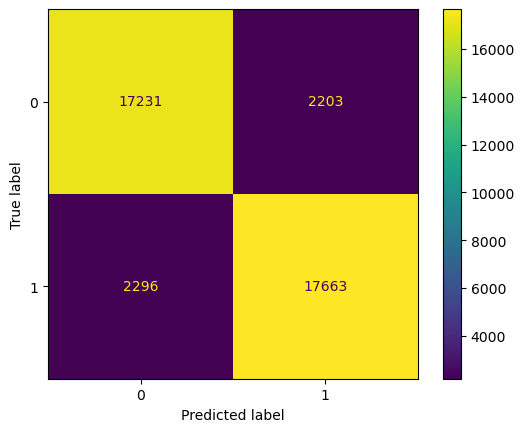

In [60]:
disp_dt.plot()
plt.show()

In [61]:
voting_clf_best_of_all = VotingClassifier(estimators=[('knn', algorithm_knn), ('lr', clf), ('dt', algorithm_tree)], 
                                          voting='soft')
algorithm_ens = voting_clf_best_of_all.fit(pred_std_train, tar_std_train)
ensemble_hard = algorithm_ens.predict(pred_std_test)

C:\Users\orteg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [62]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Rejected', 'Accepted']

In [63]:
cm_ens = confusion_matrix(tar_std_test, ensemble_hard)
group_counts = ['{0:0.0f}'.format(value) for value in
                cm_ens.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(labels,group_counts)]
labels = np.asarray(labels).reshape(2,2)
disp_ens = ConfusionMatrixDisplay(confusion_matrix=cm_ens)

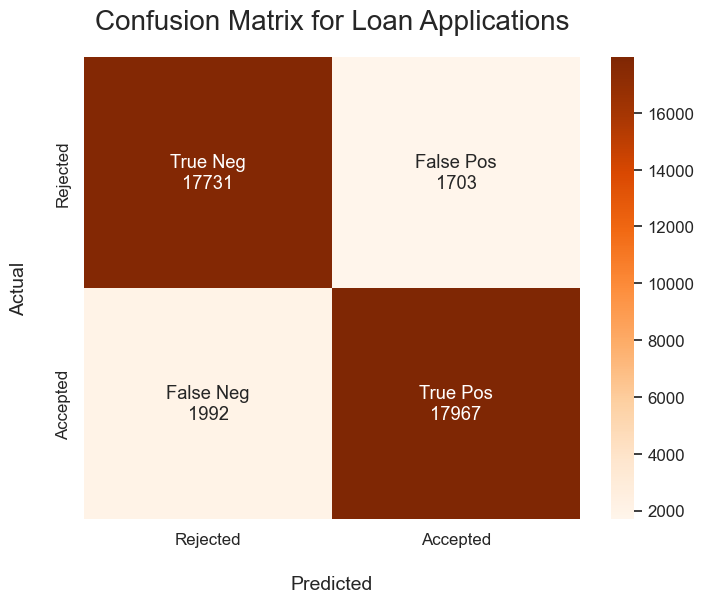

In [64]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

ax = sns.heatmap(cm_ens, annot=labels, fmt='', cmap='Oranges')
# set x-axis label and ticks. 
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Rejected', 'Accepted'])

# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Rejected', 'Accepted'])

ax.set_title("Confusion Matrix for Loan Applications", fontsize=20, pad=20)

plt.show()

In [65]:
print(classification_report(tar_std_test, ensemble_hard))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     19434
           1       0.91      0.90      0.91     19959

    accuracy                           0.91     39393
   macro avg       0.91      0.91      0.91     39393
weighted avg       0.91      0.91      0.91     39393



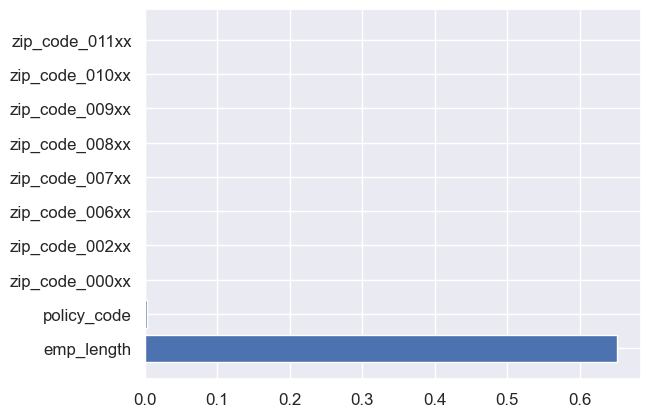

In [69]:
plt.barh(pred_std_train.columns[0:10], tree_clf.feature_importances_[0:10])
plt.show()

In [ ]:
tree_clf.feature_importances_

In [74]:
dd = tree_clf.feature_importances_
dd.sort()

print(dd[960:])

[0.00133185 0.00163999 0.00186625 0.00280039 0.00322018 0.00340755
 0.00433267 0.00535214 0.06100418 0.12859137 0.65208784]


In [77]:
thing = []
name = []
for index, column in enumerate(pred_std_train.columns):
    if column.find("zip") == -1:
        thing.append(tree_clf.feature_importances_[index])
        name.append(column)
    else:
        continue
    

In [85]:
imp = pd.DataFrame(thing,columns=['Percent of Importance'])
var = pd.DataFrame(name,columns=['Variable'])

In [86]:
importance = pd.concat([imp,var], axis=1)

In [90]:
final_imp = importance.sort_values(by='Percent of Importance', ascending=False).head(3)

In [93]:
final_imp.reset_index(inplace=True,drop=True)

In [95]:
final_imp

,Percent of Importance,Variable
0,0.652088,emp_length
1,0.128591,debt_to_income_ratio
2,0.061004,amount_requested


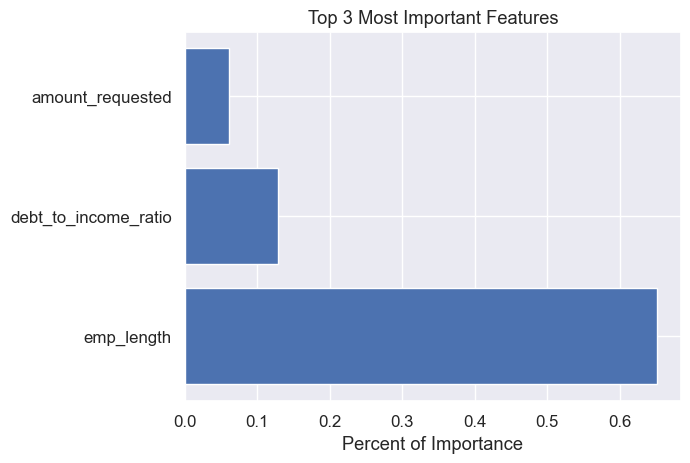

In [102]:
plt.barh(final_imp.Variable, final_imp['Percent of Importance'])
plt.title("Top 3 Most Important Features")
plt.xlabel("Percent of Importance")
plt.show()